In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-04-13 13:40:07,378: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('sentiment_tweets - Copy.csv')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           10314 non-null  int64  
 1   Tweet_Content   10314 non-null  object 
 2   negative_score  10314 non-null  float64
 3   positive_score  10314 non-null  float64
 4   neutral_score   10314 non-null  float64
 5   label           10314 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 483.6+ KB


In [9]:
df.head()

,index,Tweet_Content,negative_score,positive_score,neutral_score,label
0,106,just had a real good moment. i missssssssss hi...,0.0,0.225,0.775,0
1,217,is reading manga http://plurk.com/p/mzp1e,0.0,0.000,1.000,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0.0,0.000,1.000,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0.0,0.121,0.879,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0.0,0.000,1.000,0


In [10]:
features = df.iloc[:,2:5]
# features = features.iloc[1:]

print(features)
print(features.info())

       negative_score  positive_score  neutral_score
0               0.000           0.225          0.775
1               0.000           0.000          1.000
2               0.000           0.000          1.000
3               0.000           0.121          0.879
4               0.000           0.000          1.000
...               ...             ...            ...
10309           0.106           0.128          0.766
10310           0.167           0.113          0.721
10311           0.469           0.131          0.400
10312           0.229           0.338          0.433
10313           0.000           0.000          1.000

[10314 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   negative_score  10314 non-null  float64
 1   positive_score  10314 non-null  float64
 2   neutral_score   10314 non-null  float64
dtype

In [12]:
labels = df['label']
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
10309    1
10310    1
10311    1
10312    1
10313    1
Name: label, Length: 10314, dtype: int64


In [31]:
# from sklearn.preprocessing import MinMaxScaler

# features = MinMaxScaler().fit_transform(features)

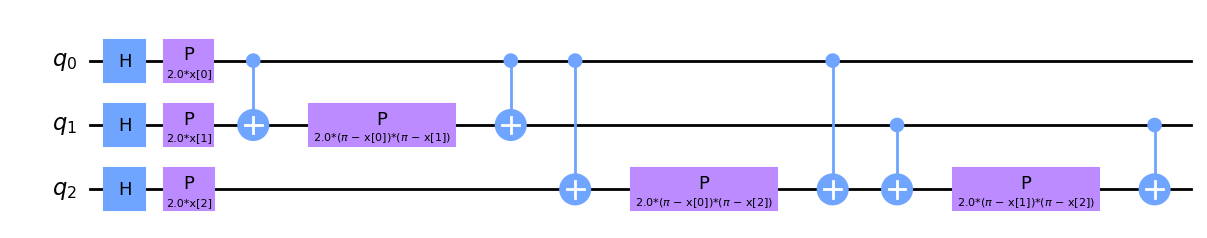

In [13]:

from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

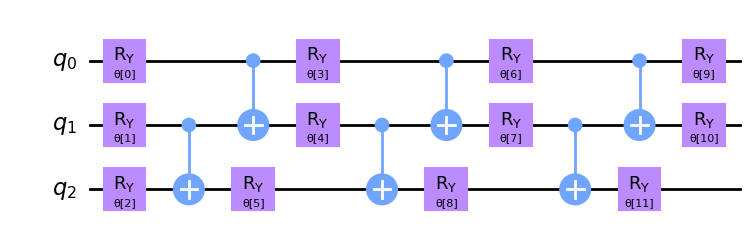

In [14]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [16]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [17]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [18]:
print(type(train_features))
# print(type(train_labels))
train_labels = np.array(train_labels)
print(type(train_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [20]:
print(train_features)
print(train_labels)

      negative_score  positive_score  neutral_score
2595           0.000           0.000          1.000
2743           0.000           0.336          0.664
4986           0.000           0.000          1.000
9913           0.142           0.042          0.816
8370           0.393           0.000          0.607
...              ...             ...            ...
9785           0.506           0.000          0.494
7763           0.000           0.238          0.762
5218           0.000           0.000          1.000
1346           0.000           0.000          1.000
3582           0.000           0.143          0.857

[8251 rows x 3 columns]
[0 0 0 ... 0 0 0]


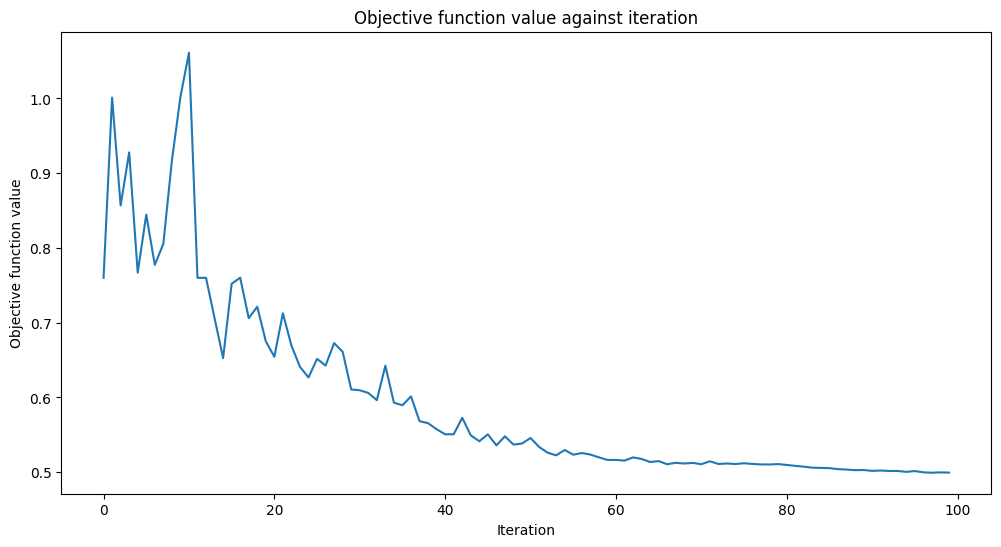

Training time: 4544 seconds
Quantum VQC on the training dataset: 0.86
Quantum VQC on the test dataset:     0.86


In [21]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import Sampler
 
sampler = Sampler()
 
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
 
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):

    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


sampler = Sampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)


print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

In [55]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.86
Quantum VQC on the test dataset:     0.86
